# ***VISION TRANSFORMER***

# **Abstract**
This project implements a Vision Transformer (ViT) model to classify images from the CIFAR-10 dataset. By extracting patches from resized images and passing them through multiple transformer layers, the model learns to classify the images accurately. The project involves data preprocessing, model building, and training the ViT classifier. The trained model is evaluated for accuracy and top-5 accuracy on the test dataset.

# **Objective**
The primary objective of this project is to develop and evaluate a Vision Transformer (ViT) model for image classification on the CIFAR-10 dataset. The project aims to demonstrate the effectiveness of transformer-based models in image classification tasks and compare the performance of the ViT model with traditional convolutional neural networks (CNNs).

# **Introduction**
Image classification is a fundamental task in computer vision, traditionally dominated by convolutional neural networks (CNNs). Recently, transformer-based models, which have shown remarkable success in natural language processing, have been adapted for vision tasks. The Vision Transformer (ViT) model processes images by splitting them into patches and applying transformer layers to capture global dependencies. This project explores the implementation and performance of a ViT model on the CIFAR-10 dataset, a widely-used benchmark for image classification.

# **Methodology**
***The project follows these steps:***

1. **Data Loading and Preprocessing:** Load the CIFAR-10 dataset and preprocess the images by resizing and normalizing them.
2. **Patch Extraction:** Define a custom layer to extract patches from the resized images.
3. **Patch Encoding:** Implement a layer to encode the patches with positional embeddings.
4. **Model Building:** Construct the ViT model with multiple transformer layers and an MLP head for classification.
5. **Training:** Train the model on the training set with appropriate loss and optimizer settings.
6. **Evaluation:** Evaluate the model on the test set and report the accuracy and top-5 accuracy.

# ***Code:***

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import tensorflow as tf
import numpy as np

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [8]:
class Patches(tf.keras.layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size,patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

In [9]:
class PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = tf.keras.layers.Dense(units=projection_dim)
    self.positional_embedding = tf.keras.layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )
  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.positional_embedding(positions)
    return encoded

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [11]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
  return x

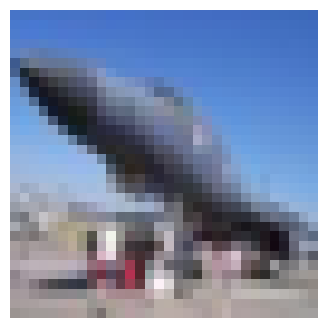

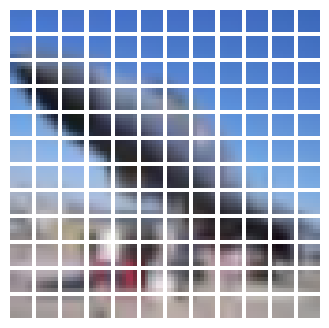

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i + 1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis('off')


In [13]:
def create_vit_classifier():
  inputs = tf.keras.layers.Input(shape=(32, 32, 3)) # Changed input shape to (32, 32, 3)
  augmented = data_augmentation(inputs)
  patches = Patches(patch_size)(augmented)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


  for _ in range(transformer_layers):
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
    x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
    # Pass x3 as input to mlp
    x4 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    encoded_patches = tf.keras.layers.Add()([x4, x2])

  representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = tf.keras.layers.Flatten()(representation)
  representation = tf.keras.layers.Dropout(0.5)(representation)
  # Pass representation as input to mlp
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
  logits = tf.keras.layers.Dense(10)(features)

  model = tf.keras.Model(inputs=inputs, outputs=logits)
  return model

In [14]:
import tensorflow_addons as tfa
def run_experiment(model, num_epochs =50):
  optimizer = tfa.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )
  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
          tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
      ],
  )
  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )
  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[checkpoint_callback],
  )
  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(accuracy, "\n")
  print(top_5_accuracy, "\n")


In [15]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/50
176/176 [==============================] - 86s 386ms/step - loss: 2.0389 - accuracy: 0.3138 - top-5-accuracy: 0.8110 - val_loss: 1.4906 - val_accuracy: 0.4680 - val_top-5-accuracy: 0.9162
Epoch 2/50
176/176 [==============================] - 74s 419ms/step - loss: 1.5377 - accuracy: 0.4479 - top-5-accuracy: 0.9020 - val_loss: 1.2299 - val_accuracy: 0.5600 - val_top-5-accuracy: 0.9498
Epoch 3/50
176/176 [==============================] - 74s 419ms/step - loss: 1.3893 - accuracy: 0.5050 - top-5-accuracy: 0.9252 - val_loss: 1.1686 - val_accuracy: 0.5890 - val_top-5-accuracy: 0.9564
Epoch 4/50
176/176 [==============================] - 69s 391ms/step - loss: 1.2888 - accuracy: 0.5423 - top-5-accuracy: 0.9381 - val_loss: 1.0703 - val_accuracy: 0.6198 - val_top-5-accuracy: 0.9622
Epoch 5/50
176/176 [==============================] - 68s 388ms/step - loss: 1.2171 - accuracy: 0.5684 - top-5-accuracy: 0.9464 - val_loss: 1.0208 - val_accuracy: 0.6462 - val_top-5-accuracy: 0.9686
Epoch

# **Conclusion**
The Vision Transformer (ViT) model demonstrates the capability of transformer architectures for image classification tasks. By dividing images into patches and applying transformer layers, the ViT model achieves competitive performance on the CIFAR-10 dataset. This project highlights the potential of transformer models in computer vision and provides a foundation for further exploration and optimization in various image classification applications.